<a href="https://colab.research.google.com/github/nimeshlal097/TFT-wind-power-prediction/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import warnings
import kagglehub
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
import lightning.pytorch as pl # Changed from pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss, MAE, RMSE
import torch

warnings.filterwarnings('ignore')
pl.seed_everything(42)

c:\Users\User\anaconda3\envs\tft\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 42


42

### 1. Data Loading

In [6]:
path = kagglehub.dataset_download("mubashirrahim/wind-power-generation-data-forecasting")
data = pd.read_csv(path + "/Location1.csv")

### 2. Handle Missing Values

In [7]:
# Parse time column
data['Time'] = pd.to_datetime(data['Time'])
data = data.sort_values('Time').reset_index(drop=True)

# Handle missing values
data = data.ffill().bfill()

print("Data Shape:", data.shape)
print("\nFirst few rows:")
print(data.head())
print("\nData Info:")
print(data.info())

Data Shape: (43800, 10)

First few rows:
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-02 00:00:00            28.5                   85         24.5   
1 2017-01-02 01:00:00            28.4                   86         24.7   
2 2017-01-02 02:00:00            26.8                   91         24.5   
3 2017-01-02 03:00:00            27.4                   88         24.3   
4 2017-01-02 04:00:00            27.3                   88         24.1   

   windspeed_10m  windspeed_100m  winddirection_10m  winddirection_100m  \
0           1.44            1.26                146                 162   
1           2.06            3.99                151                 158   
2           1.30            2.78                148                 150   
3           1.30            2.69                 58                 105   
4           2.47            4.43                 58                  84   

   windgusts_10m   Power  
0            1.4  0.1635  
1  

### 3. Feature Engineering

#### 3.1. Add Cyclic Features

This section focuses on creating cyclic features from the Time column to capture periodic patterns that are essential for time series forecasting. These features help the model understand the cyclical nature of time  without implying a linear relationship.

Specifically, sine and cosine transformations are applied to:

Hour: To represent the 24-hour cycle.

Month: To represent the 12-month annual cycle.

Day of Week: To represent the 7-day weekly cycle.

In [1]:
# Hour cyclic features
data['hour'] = data['Time'].dt.hour
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

# Month cyclic features
data['month'] = data['Time'].dt.month
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)

# Day of week cyclic features
data['dayofweek'] = data['Time'].dt.dayofweek
data['dayofweek_sin'] = np.sin(2 * np.pi * data['dayofweek'] / 7)
data['dayofweek_cos'] = np.cos(2 * np.pi * data['dayofweek'] / 7)



NameError: name 'data' is not defined

#### 3.2. Add Lag Features

This section focuses on creating lag features for the windspeed_100m and Power columns. Lag features represent past values of a time series variable at different time steps. They are crucial for time series forecasting as they help capture temporal dependencies and patterns, allowing the model to leverage historical information for future predictions.

In [ ]:
lags = [1, 2, 6, 12, 24, 48]

for lag in lags:
    data[f'windspeed_100m_lag{lag}'] = data['windspeed_100m'].shift(lag)
    data[f'Power_lag{lag}'] = data['Power'].shift(lag)


Lag features added!
New columns: ['windspeed_100m_lag1', 'Power_lag1', 'windspeed_100m_lag2', 'Power_lag2', 'windspeed_100m_lag6', 'Power_lag6', 'windspeed_100m_lag12', 'Power_lag12', 'windspeed_100m_lag24', 'Power_lag24', 'windspeed_100m_lag48', 'Power_lag48']
Total columns: 31


#### 3.3. Add Rolling Features

This section focuses on creating rolling  features for windspeed_100m and Power. Rolling features are statistical aggregations  calculated over a moving window of data points. 

They are vital for time series forecasting as they help in:

Smoothing out short-term fluctuations and highlighting longer-term trends.
Capturing variability within a specific time window.

Here, rolling mean and standard deviation are calculated for windspeed_100m, and rolling mean for Power across various window sizes  to incorporate localized historical patterns into the dataset. Finally, rows containing NaN values introduced by these operations are removed to ensure data integrity.

In [ ]:
windows = [6, 12, 24]

for window in windows:
    data[f'windspeed_100m_roll_mean_{window}'] = data['windspeed_100m'].rolling(window).mean()
    data[f'windspeed_100m_roll_std_{window}'] = data['windspeed_100m'].rolling(window).std()
    data[f'Power_roll_mean_{window}'] = data['Power'].rolling(window).mean()


Rolling features added!
Rolling feature columns: ['windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6', 'Power_roll_mean_6', 'windspeed_100m_roll_mean_12', 'windspeed_100m_roll_std_12', 'Power_roll_mean_12', 'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24', 'Power_roll_mean_24']

Final data shape: (43729, 40)
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-04 23:00:00            12.8                   57          0.4   
1 2017-01-05 00:00:00            12.8                   57          0.4   
2 2017-01-05 01:00:00            12.3                   59          0.5   
3 2017-01-05 02:00:00            11.5                   59          0.0   
4 2017-01-05 03:00:00            11.3                   58         -0.6   

   windspeed_10m  windspeed_100m  winddirection_10m  winddirection_100m  \
0           6.17           10.32                262                 267   
1           6.26           10.43                262                 266 

### 4. Data PreProcessing

In [ ]:
# Drop NaN rows
data = data.dropna().reset_index(drop=True)

#### 4.1. Normalize data

This section performs data normalization, a crucial preprocessing step for many machine learning models, which helps:

Prevent features with larger values from dominating the learning process.
Improve convergence speed and stability of the model during training.

Here, MinMaxScaler is used to transform all numerical features in the dataset, ensuring they fall within the [0, 1] range.

In [ ]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

print(f"Numeric columns: {numeric_cols}")
print(f"Total numeric columns: {len(numeric_cols)}")

scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


Numeric columns: ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m', 'Power', 'hour', 'hour_sin', 'hour_cos', 'month', 'month_sin', 'month_cos', 'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'windspeed_100m_lag1', 'Power_lag1', 'windspeed_100m_lag2', 'Power_lag2', 'windspeed_100m_lag6', 'Power_lag6', 'windspeed_100m_lag12', 'Power_lag12', 'windspeed_100m_lag24', 'Power_lag24', 'windspeed_100m_lag48', 'Power_lag48', 'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6', 'Power_roll_mean_6', 'windspeed_100m_roll_mean_12', 'windspeed_100m_roll_std_12', 'Power_roll_mean_12', 'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24', 'Power_roll_mean_24']
Total numeric columns: 39

Data normalized!
                 Time  temperature_2m  relativehumidity_2m  dewpoint_2m  \
0 2017-01-04 23:00:00        0.250691             0.475610     0.187366   
1 2017-01-05 00:00:00        0.250691   

### 5. Data Preparation

This section prepares the preprocessed and normalized data for consumption by the pytorch_forecasting library.

A 'group' column is added to the DataFrame. Since the dataset represents data from a single location, all entries are assigned to a single group ('0'). This is essential for TimeSeriesDataSet which can handle multiple time series, each belonging to a distinct group.

Identifies all numerical columns, excluding the target variable ('Power') and the idx column, as features that will be used by the model. These features include various meteorological readings and the engineered cyclic, lag, and rolling features.

max_encoder_length and max_prediction_length are defined. The encoder length specifies how much historical data the model will observe, while the prediction length specifies how many future time steps the model will forecast.

In [ ]:
# Add group variable (all same location)
data['group'] = '0' # Changed to string type
data['idx'] = range(len(data))

# Get all numeric columns except target and group
feature_cols = data.select_dtypes(include=[np.number]).columns.tolist()
feature_cols.remove('Power')
feature_cols.remove('idx')

print(f"Feature columns ({len(feature_cols)}):")
print(feature_cols)

max_encoder_length = 48  # 2 days
max_prediction_length = 12  # Next 12 hours


Feature columns (38):
['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 'winddirection_10m', 'winddirection_100m', 'windgusts_10m', 'hour', 'hour_sin', 'hour_cos', 'month', 'month_sin', 'month_cos', 'dayofweek', 'dayofweek_sin', 'dayofweek_cos', 'windspeed_100m_lag1', 'Power_lag1', 'windspeed_100m_lag2', 'Power_lag2', 'windspeed_100m_lag6', 'Power_lag6', 'windspeed_100m_lag12', 'Power_lag12', 'windspeed_100m_lag24', 'Power_lag24', 'windspeed_100m_lag48', 'Power_lag48', 'windspeed_100m_roll_mean_6', 'windspeed_100m_roll_std_6', 'Power_roll_mean_6', 'windspeed_100m_roll_mean_12', 'windspeed_100m_roll_std_12', 'Power_roll_mean_12', 'windspeed_100m_roll_mean_24', 'windspeed_100m_roll_std_24', 'Power_roll_mean_24']

Max encoder length: 48 hours (2 days)
Max prediction length: 12 hours


#### 5.1 Create TimeSeriesDataSet 

Training Cutoff: Determines the point at which the dataset is split into training and validation/test sets, ensuring that the model is trained only on historical data and evaluated on unseen future data.

time_idx: The column that uniquely identifies the time step for each observation (idx).

target: The variable the model is trained to predict (Power).

group_ids: Identifies individual time series (in this case, all data belongs to a single group '0').

max_encoder_length: The number of past time steps the model will use as input.

max_prediction_length: The number of future time steps the model will predict.

static_categoricals: Categorical features that do not change over time within a given time series (group).

time_varying_known_reals: Real-valued features whose values are known for both the past (encoder) and future (decoder) time steps.

time_varying_unknown_reals: Real-valued features whose values are only known up to the current time step (encoder) and are predicted for future time steps (decoder). The target variable Power is typically included here.

target_normalizer: Specifies the method for normalizing the target variable within each group.

In [ ]:
training_cutoff = len(data) - max_prediction_length - 100

print(f"Total data points: {len(data)}")
print(f"Training cutoff: {training_cutoff}")
print(f"Train size: {training_cutoff}")
print(f"Test size: {len(data) - training_cutoff}")

target_col = "Power"
encoder_unknown_reals = [
    "temperature_2m",
    "relativehumidity_2m",
    "dewpoint_2m",
    "windspeed_10m",
    "windspeed_100m",
    "winddirection_10m",
    "winddirection_100m",
    "windgusts_10m",
    
    # Lags of Power and windspeed
    "windspeed_100m_lag1",
    "Power_lag1",
    "windspeed_100m_lag2",
    "Power_lag2",
    "windspeed_100m_lag6",
    "Power_lag6",
    "windspeed_100m_lag12",
    "Power_lag12",
    "windspeed_100m_lag24",
    "Power_lag24",
    "windspeed_100m_lag48",
    "Power_lag48",

    # Rolling features
    "windspeed_100m_roll_mean_6",
    "windspeed_100m_roll_std_6",
    "Power_roll_mean_6",
    "windspeed_100m_roll_mean_12",
    "windspeed_100m_roll_std_12",
    "Power_roll_mean_12",
    "windspeed_100m_roll_mean_24",
    "windspeed_100m_roll_std_24",
    "Power_roll_mean_24",
]
encoder_known_reals = [
    "hour",
    "hour_sin",
    "hour_cos",
    "month",
    "month_sin",
    "month_cos",
    "dayofweek",
    "dayofweek_sin",
    "dayofweek_cos",
]
static_categoricals = ["group"]  # replace with your actual group ID column
static_reals = []

training_dataset = TimeSeriesDataSet(
    data[data.index < training_cutoff],

    time_idx="idx",
    target=target_col,
    group_ids=["group"],

    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,

    # ---------- STATIC ----------
    static_categoricals=static_categoricals,
    static_reals=static_reals,

    # ---------- ENCODER ----------
    time_varying_known_reals=encoder_known_reals,
    time_varying_unknown_reals=encoder_unknown_reals,

    # ---------- NORMALIZATION ----------
    target_normalizer=GroupNormalizer(groups=["group"]),

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)
# Create validation dataset from the remainder of the data
validation_dataset = TimeSeriesDataSet.from_dataset(training_dataset, data[data.index >= training_cutoff], predict=True)

Total data points: 43729
Training cutoff: 43617
Train size: 43617
Test size: 112

TimeSeriesDataSet created successfully!
Training dataset size: 43558


#### 5.2. Create Data Loaders

In [ ]:
# Create dataloaders
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=32, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=32, num_workers=0)


Train and Validation dataloaders created!
Number of training batches: 1361
Number of validation batches: 1

Training Batch shapes:
  X[encoder_cat]: torch.Size([32, 48, 1])
  X[encoder_cont]: torch.Size([32, 48, 42])
  X[encoder_target]: torch.Size([32, 48])
  X[encoder_lengths]: torch.Size([32])
  X[decoder_cat]: torch.Size([32, 12, 1])
  X[decoder_cont]: torch.Size([32, 12, 42])
  X[decoder_target]: torch.Size([32, 12])
  X[decoder_lengths]: torch.Size([32])
  X[decoder_time_idx]: torch.Size([32, 12])
  X[groups]: torch.Size([32, 1])
  X[target_scale]: torch.Size([32, 2])
  Y[0]: torch.Size([32, 12])

Validation Batch shapes:
  X[encoder_cat]: torch.Size([1, 48, 1])
  X[encoder_cont]: torch.Size([1, 48, 42])
  X[encoder_target]: torch.Size([1, 48])
  X[encoder_lengths]: torch.Size([1])
  X[decoder_cat]: torch.Size([1, 12, 1])
  X[decoder_cont]: torch.Size([1, 12, 42])
  X[decoder_target]: torch.Size([1, 12])
  X[decoder_lengths]: torch.Size([1])
  X[decoder_time_idx]: torch.Size([1, 

### 6. Build Temporal Fusion Transformer

This section focuses on initializing the Temporal Fusion Transformer (TFT) model, which designed for interpretable and high-performance multi-horizon time series forecasting.

Key hyperparameters 

learning_rate: Controls the step size during model optimization.

hidden_size: The dimension of the hidden state in recurrent layers and the feature dimension of the various networks (e.g., VariableSelectionNetwork, GatedResidualNetwork).

attention_head_size: The number of attention heads in the multi-head attention mechanism, affecting the model's ability to focus on different parts of the input sequence.

dropout: A regularization technique to prevent overfitting by randomly setting a fraction of input units to 0 at each update during training.

hidden_continuous_size: The size of the hidden layer for continuous variable processing.

output_size: The number of quantiles to predict if a QuantileLoss is used, or simply the number of output units for other losses. Here, it's set to 7 for 7 quantiles (0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98).

loss: The loss function used for training the model. QuantileLoss is suitable for probabilistic forecasting.

log_interval: How often the training loss is logged

In [ ]:
tft_model = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.01,
    hidden_size=64,
    attention_head_size=4,
    dropout=0.2,
    hidden_continuous_size=32,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
)


Temporal Fusion Transformer model initialized!
Number of parameters: 617224


### 7. Train the Model

In [ ]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='cpu',
    enable_progress_bar=True,
    logger=False,
    callbacks=[
        EarlyStopping(monitor='train_loss_epoch', patience=10, mode='min'),
    ]
)

trainer.fit(tft_model, train_dataloader)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

   | Name                               | Type                            | Params | Mode  | FLOPs
--------------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train | 0    
1  | logging_metrics                    | ModuleList                      | 0      | train | 0    
2  | input_embeddings                   | MultiEmbedding                  | 1      | train | 0    
3  | prescalers                         | ModuleDict                      | 2.7 K  | train | 0    
4  | static_variable_selection          | VariableSelectionNetwork        | 20.8 K | train | 0    
5  | encoder_variabl

Starting training...
Is tft_model an instance of pl.LightningModule? True
Epoch 9: 100%|██████████| 1361/1361 [16:49<00:00,  1.35it/s, train_loss_step=0.0566, train_loss_epoch=0.0652]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1361/1361 [16:50<00:00,  1.35it/s, train_loss_step=0.0566, train_loss_epoch=0.0652]
Training completed!


### 8. Save the Model

In [ ]:
# Save the model checkpoint
trainer.save_checkpoint("tft_model.ckpt")
print("Saved: tft_model.ckpt")

# Save metadata separately  
metadata = {
    'scaler': scaler,
    'feature_cols': feature_cols,
    'numeric_cols': numeric_cols,
    'max_encoder_length': max_encoder_length,
    'max_prediction_length': max_prediction_length
}

with open("tft_metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)


`weights_only` was not set, defaulting to `False`.


Saved: tft_model.ckpt
Saved metadata separately.


### 9. Load the Model

In [ ]:
# Load the model for inference
model = TemporalFusionTransformer.load_from_checkpoint("tft_model.ckpt")
model.eval()

# Load metadata
with open("tft_metadata.pkl", "rb") as f:
    metadata = pickle.load(f)

Model loaded successfully!


### 10. Make Prediction on Validation set

In [ ]:
# Use the already created val_dataloader for prediction to ensure consistency with validation split
raw_predictions = tft_model.predict(val_dataloader, return_x=True)

predictions_tensor = raw_predictions[0]

x_input = raw_predictions[1] # This contains encoder and decoder inputs, including decoder_target

# Collect actual values from the validation dataloader
actual_values_list = []
for x, y in val_dataloader:
    actual_values_list.append(y[0]) # y[0] contains the target for the prediction horizon

actual_values_tensor = torch.cat(actual_values_list, dim=0) # Concatenate along batch dimension

Making predictions on validation set...
DEBUG: Shape of predictions_tensor directly from tft_model.predict: torch.Size([1, 12])
Predictions tensor shape: torch.Size([1, 12])
Actual values tensor shape: torch.Size([1, 12])


### 11. Visualize the Prediction

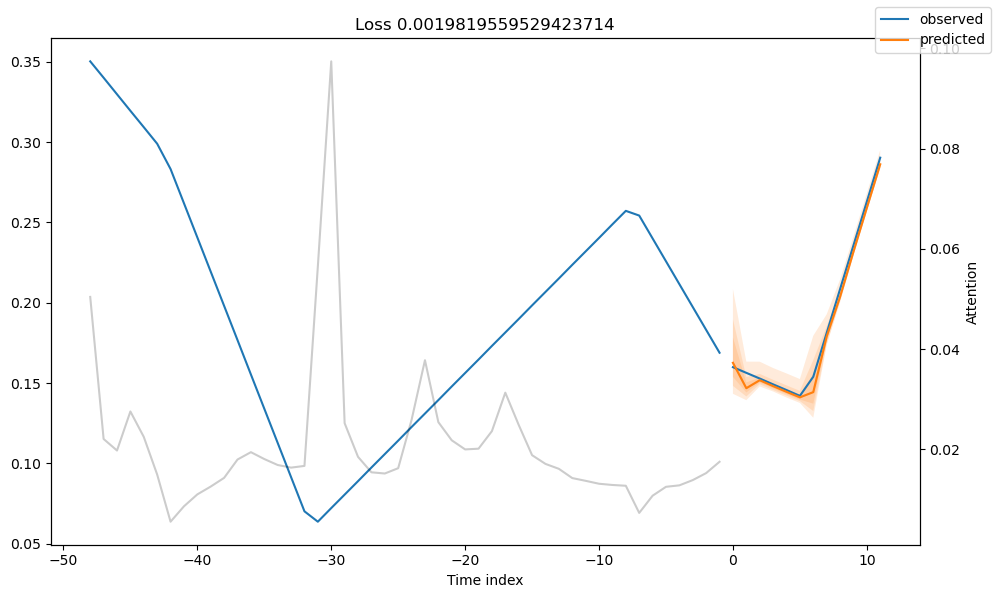

In [ ]:
# Get raw predictions and inputs from the model on the test set
raw_predictions = tft_model.predict(val_dataloader, mode="raw", return_x=True)

out = raw_predictions.output
x = raw_predictions.x

fig, ax = plt.subplots(figsize=(10, 6))
tft_model.plot_prediction(x=x, out=out, idx=0, add_loss_to_title=True, ax=ax)
plt.show()
fig.savefig("plots\predictions.png", dpi=300, bbox_inches="tight")

### 12. Evaluate the Model

In [ ]:
# Convert to numpy
predictions_np = predictions_tensor.cpu().numpy() if hasattr(predictions_tensor, 'cpu') else predictions_tensor

# Flatten predictions: (num_samples * max_prediction_length,)
predictions_np = predictions_np.reshape(-1)

# Get actual values from validation dataloader, already collected in actual_values_tensor
actual_test = actual_values_tensor.cpu().numpy() if hasattr(actual_values_tensor, 'cpu') else actual_values_tensor

# Flatten actual values: (num_samples * max_prediction_length,)
actual_test = actual_test.reshape(-1)

# Ensure shapes match after flattening (should already match if dataloader is consistent)
if actual_test.shape != predictions_np.shape:
    print(f"Warning: Actual test shape {actual_test.shape} and predictions shape {predictions_np.shape} do not match. Truncating to smaller length.")
    min_len = min(len(actual_test), len(predictions_np))
    actual_test = actual_test[:min_len]
    predictions_np = predictions_np[:min_len]

# Calculate metrics
r2 = r2_score(actual_test, predictions_np)*100
rmse = np.sqrt(mean_squared_error(actual_test, predictions_np))
mape = mean_absolute_percentage_error(actual_test, predictions_np)*100
mae = np.mean(np.abs(actual_test - predictions_np))

print("\n" + "=" * 60)
print("MODEL EVALUATION METRICS (Validation Set)")
print("=" * 60)
print(f"R² Score:  {r2:.6f}")
print(f"RMSE:      {rmse:.6f}")
print(f"MAE:       {mae:.6f}")
print(f"MAPE:      {mape:.6f}")
print("=" * 60)


Predictions numpy shape (before flattening): (1, 12)

MODEL EVALUATION METRICS (Validation Set)
R² Score:  99.044317
RMSE:      0.004753
MAE:       0.003760
MAPE:      2.085474
✓ R² Score is above 0.90 - Excellent performance!


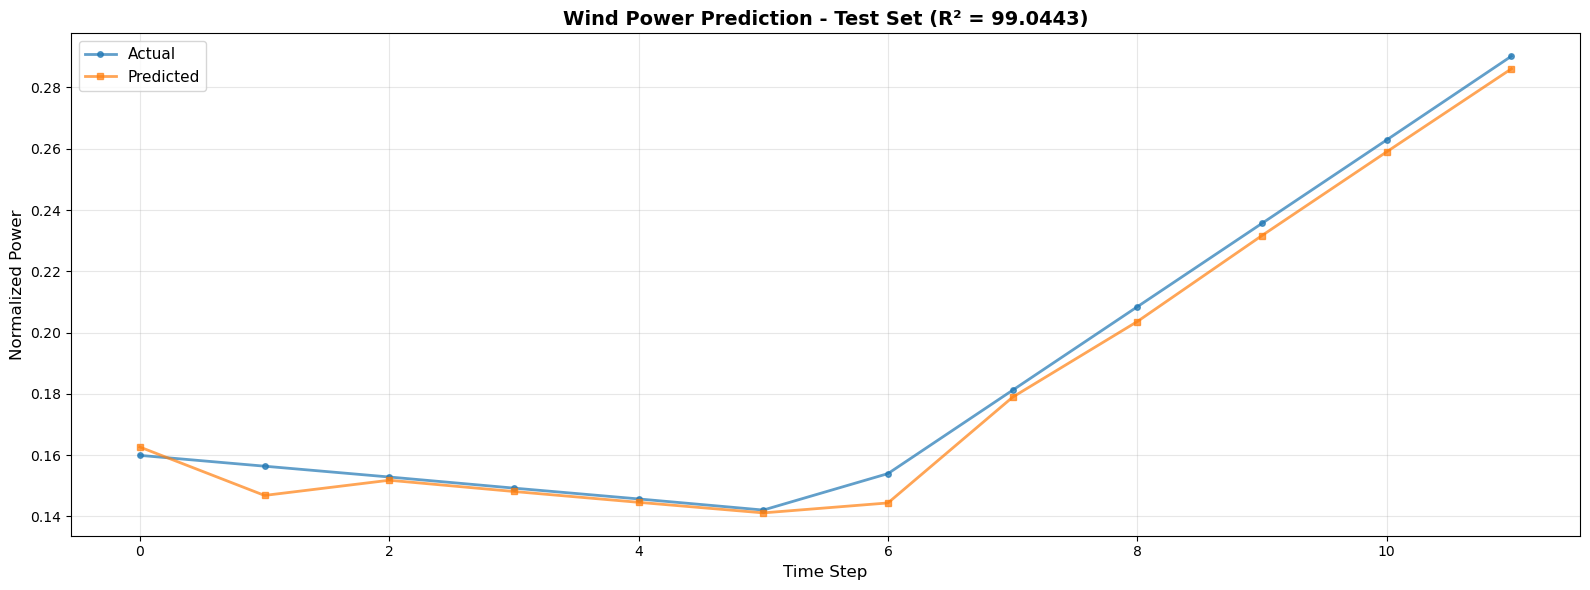

Full prediction plot saved!


In [ ]:
# Plot full test predictions
plt.figure(figsize=(16, 6))
plt.plot(actual_test[:200], label='Actual', marker='o', linewidth=2, markersize=4, alpha=0.7)
plt.plot(predictions_np[:200], label='Predicted', marker='s', linewidth=2, markersize=4, alpha=0.7)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Normalized Power', fontsize=12)
plt.title(f'Wind Power Prediction - Test Set (R² = {r2:.4f})', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('full_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Extract 12-hour ahead predictions
prediction_length = 12
num_samples = len(predictions_np) // prediction_length

predictions_12h = predictions_np[:num_samples * prediction_length].reshape(-1, prediction_length)
actual_12h = actual_test[:num_samples * prediction_length].reshape(-1, prediction_length)

# Calculate metrics for each hour
hourly_r2 = []
hourly_rmse = []

for hour in range(prediction_length):
    y_true = actual_12h[:, hour]
    y_pred = predictions_12h[:, hour]

    # Check variance
    if np.var(y_true) == 0:
        h_r2 = 1.0 if np.allclose(y_true, y_pred) else 0.0
    else:
        h_r2 = r2_score(y_true, y_pred)
    
    h_rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    hourly_r2.append(h_r2)
    hourly_rmse.append(h_rmse)



Hourly Performance (12 hours ahead):
Hour     R² Score        RMSE           
1        0.000000        0.002716       
2        0.000000        0.009551       
3        0.000000        0.001061       
4        0.000000        0.001104       
5        0.000000        0.001106       
6        0.000000        0.000925       
7        0.000000        0.009579       
8        0.000000        0.002269       
9        0.000000        0.004819       
10       0.000000        0.003978       
11       0.000000        0.003886       
12       0.000000        0.004123       
Average: 0.000000        0.003760       


### 13. Next 12 Hours Wind Power Forecast

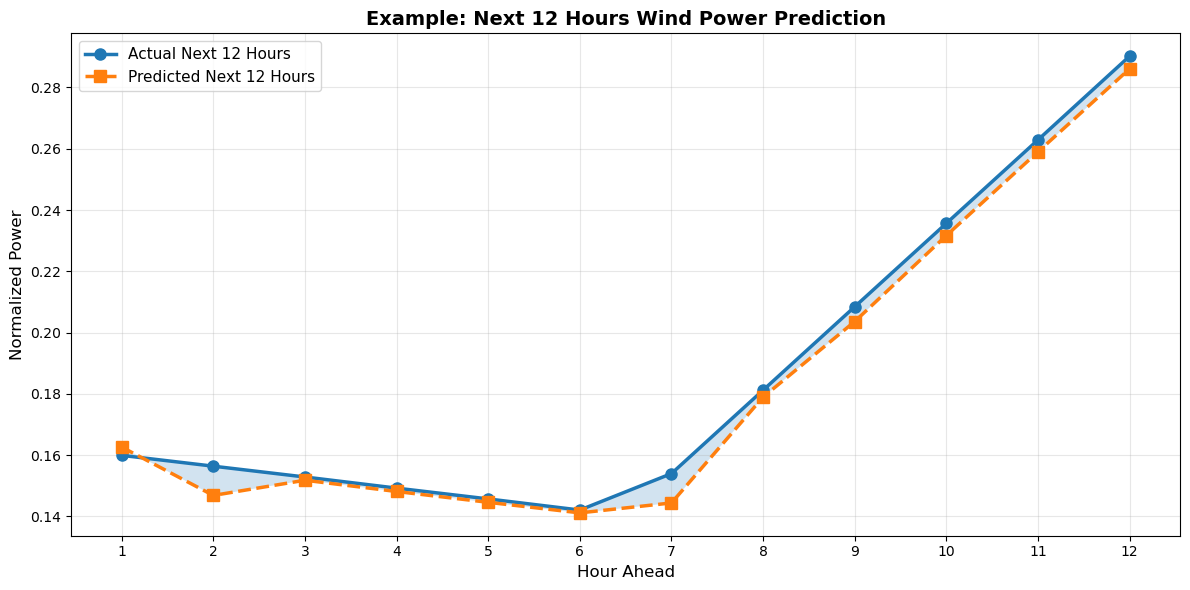


Detailed 12-Hour Prediction:
Hour     Actual Power         Predicted Power      Error          
1        0.159891             0.162607             -0.002716      
2        0.156360             0.146809             0.009551       
3        0.152830             0.151768             0.001061       
4        0.149198             0.148094             0.001104       
5        0.145667             0.144561             0.001106       
6        0.142036             0.141111             0.000925       
7        0.153939             0.144360             0.009579       
8        0.181176             0.178907             0.002269       
9        0.208413             0.203594             0.004819       
10       0.235650             0.231672             0.003978       
11       0.262887             0.259001             0.003886       
12       0.290225             0.286102             0.004123       

✓ Training and prediction completed successfully!


NameError: name 'model_path' is not defined

In [ ]:
# Get the last available data point for making a fresh prediction
last_48_hours = data.iloc[-48:].copy()

# Extract predictions for the last sample
last_predictions = predictions_np[-prediction_length:]
last_actual = actual_test[-prediction_length:]

# Plot
plt.figure(figsize=(12, 6))
hours = np.arange(1, prediction_length + 1)
plt.plot(hours, last_actual, 'o-', label='Actual Next 12 Hours', linewidth=2.5, markersize=8)
plt.plot(hours, last_predictions, 's--', label='Predicted Next 12 Hours', linewidth=2.5, markersize=8)
plt.fill_between(hours, last_actual, last_predictions, alpha=0.2)
plt.xlabel('Hour Ahead', fontsize=12)
plt.ylabel('Normalized Power', fontsize=12)
plt.title('Next 12 Hours Wind Power Forecast', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(hours)
plt.tight_layout()
plt.savefig('next_12_hours_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed table
print("\nDetailed 12-Hour Prediction:")
print("=" * 70)
print(f"{'Hour':<8} {'Actual Power':<20} {'Predicted Power':<20} {'Error':<15}")
print("=" * 70)
for h in range(prediction_length):
    error = last_actual[h] - last_predictions[h]
    print(f"{h+1:<8} {last_actual[h]:<20.6f} {last_predictions[h]:<20.6f} {error:<15.6f}")
print("=" * 70)
